In [45]:
import pandas as pd
import numpy as np
import seaborn as sns


# Importing the data

In [46]:
df_books = pd.read_csv('best_books_goodreads.csv', dtype={'awards':object})
df_books_raw = df_books

# General cleaning

In [47]:
df_books.columns

Index(['bookId', 'title', 'series', 'author', 'rating', 'description',
       'language', 'isbn', 'genres', 'characters', 'bookFormat', 'edition',
       'pages', 'publisher', 'publishDate', 'firstPublishDate', 'awards',
       'numRatings', 'ratingsByStars', 'likedPercent', 'setting', 'coverImg',
       'bbeScore', 'bbeVotes', 'price'],
      dtype='object')

In [48]:
# Dropping unnecessary columns
df_books.drop(columns=['description', 'language', 'characters', 'bookFormat','edition','publisher','likedPercent',
                        'setting', 'coverImg', 'bbeScore', 'bbeVotes', 'price'], inplace=True)
df_books.head(1)

,bookId,title,series,author,rating,isbn,genres,pages,publishDate,firstPublishDate,awards,numRatings,ratingsByStars
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",374,09/14/08,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93..."


In [49]:
# Removing books without ISBN
print('Lenght before ',len(df_books))
df_books = df_books[df_books['isbn']!= '9999999999999']
print('Lenght after ',len(df_books))

Lenght before  52478
Lenght after  48124


### Removing books under median number of ratings

In [50]:
# Verification function just to not filter twice
if len(df_books) == 48124:
    median_num_ratings = df_books['numRatings'].fillna(value=0).astype(int).quantile(0.5)
    print("Len before filtering 0.5 best books:", len(df_books))
    df_books = df_books[df_books['numRatings'] > median_num_ratings].copy()
    print("Len after:", len(df_books))
else:
    print('Already filtered')
    print("Len after:", len(df_books))

Len before filtering 0.75 best books: 48124
Len after: 24060


### Removing books with wrong or outlier page count

In [51]:
# Filtering multiple errors in page column

# '1 page' error
df_books = df_books[df_books['pages']!='1 page']

# NA error
df_books = df_books[~df_books['pages'].isna()]

# Books with 0 pages
df_books = df_books[df_books['pages'] != 0]

# Removing books with less than 10 pages and more than 2_000 pages
min_num_of_pages = 10
max_num_of_pages = 2000 # The 2000 number was decided after viewing the distribution and seeing that this threshold contains most books. Out of this range books will be consider outliers

df_books['pages'] = df_books['pages'].astype(int)
df_books = df_books[df_books['pages'] < max_num_of_pages]
df_books = df_books[df_books['pages'] > min_num_of_pages]

# Calculating success metrics against number of pages

### Normalizing rating

In [52]:
# Creating normalized rating column
df_books['norm_rating'] = df_books['rating']/5
df_books[['title','norm_rating']].sort_values(by='norm_rating', ascending=False).head(3)

,title,norm_rating
256,The Complete Calvin and Hobbes,0.964
26500,"The Way of Kings, Part 2",0.958
9529,Nutuk,0.958


### Normalizing number of awards

In [53]:
from ast import literal_eval

# Converting list columns into list type
df_books['awards'] = df_books['awards'].apply(literal_eval)

# Creating column with the number of awards for each book
df_books['num_awards'] = df_books['awards'].apply(len)

# Calculating the maximum number of awards and printing it
max_num_awards = max(df_books['num_awards'])
print("Max number of awards: ", max_num_awards)

# Creating the normalized number of awards column
df_books['norm_num_awards'] = df_books['num_awards']/max_num_awards
df_books[['title','norm_num_awards']].sort_values(by='norm_num_awards', ascending=False).head(3)

Max number of awards:  41


,title,norm_num_awards
0,The Hunger Games,1.000000
5355,Escape from Mr. Lemoncello's Library,0.658537
4,Twilight,0.609756


### Normalizing number of ratings

In [54]:
# Calculating the maximum number of ratings
max_num_ratings = max(df_books['numRatings'])
print("Max number of ratings: ", max_num_ratings)

# Creating the column with maximum number of ratings
df_books['norm_num_ratings'] = df_books['numRatings']/max_num_ratings
df_books[['title', 'norm_num_ratings']].sort_values(by='norm_num_ratings', ascending=False).head(3)


Max number of ratings:  6376780


,title,norm_num_ratings
0,The Hunger Games,1.000000
4,Twilight,0.778531
80,1984,0.492481


### Creating derived success measure

In [55]:
# Defining the weights
weights = {
    'avg_rating': 1,
    'num_awards': 2,
    'num_ratings': 1
}

# Calculating the success rate
df_books['success_rate'] = (df_books['norm_num_awards']*weights['num_awards']+\
                           df_books['norm_num_ratings']*weights['num_ratings']+\
                           df_books['norm_rating']*weights['avg_rating'])/sum(weights.values())

# Visualizing most successful books 
df_books[['title', 'success_rate']].sort_values(by='success_rate', ascending=False).head(3)

,title,success_rate
0,The Hunger Games,0.966500
4,Twilight,0.679511
21,Divergent,0.567342


### Cleaning number of pages column

### Quickly visualizing the distribution of number of pages

In [56]:
df_books['pages'].describe()

count    23711.000000
mean       346.336637
std        176.401959
min         11.000000
25%        243.000000
50%        329.000000
75%        413.000000
max       1952.000000
Name: pages, dtype: float64

### Creating an object with the number of pages and the average sucess rate:

In [57]:
df_books.columns

Index(['bookId', 'title', 'series', 'author', 'rating', 'isbn', 'genres',
       'pages', 'publishDate', 'firstPublishDate', 'awards', 'numRatings',
       'ratingsByStars', 'norm_rating', 'num_awards', 'norm_num_awards',
       'norm_num_ratings', 'success_rate'],
      dtype='object')

<Axes: xlabel='pages', ylabel='success_rate'>

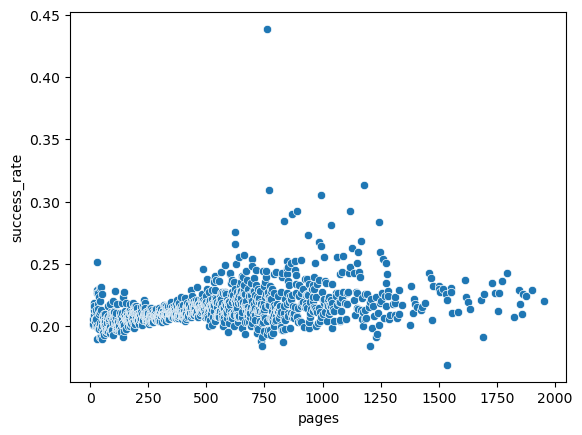

In [58]:
# Calculating the average success rate by number of pages
success_by_num_pages = df_books.groupby('pages').agg({
    'success_rate':'mean',
    'norm_rating':'mean',
    'norm_num_awards':'mean',
    'norm_num_ratings':'mean',
    })
sns.scatterplot(success_by_num_pages['success_rate'])

In [59]:
import json

# Exporting sucess rate by number of pages
def export_json(data, filename):    
    with open(f'./output/{filename}.json', 'w') as f:
        json.dump(data, f)

export_json(dict(success_by_num_pages['success_rate']), 'success_by_pages/success_rate_by_num_pages')
export_json(dict(success_by_num_pages['norm_rating']), 'success_by_pages/norm_rating_by_num_pages')
export_json(dict(success_by_num_pages['norm_num_awards']), 'success_by_pages/norm_num_awards_by_num_pages')
export_json(dict(success_by_num_pages['norm_num_ratings']), 'success_by_pages/norm_num_ratings_by_num_pages')

# Linking genres two by two

### Creating genre:book dictionary

In [60]:
from collections import defaultdict

# Formatting the genres column
df_books['genres'] = df_books['genres'].apply(literal_eval)

# Initialize defaultdict books by genre
genre_dict = defaultdict(list)

# Loop through each row in the dataframe to get the books in each genre
for index, row in df_books.iterrows():
    book_name = row['title']
    genres = row['genres']
    for genre in genres:
        genre_dict[genre].append(book_name)

# Dictionary that stores the books that are into each genre
books_by_genre_dict = dict(genre_dict)

# Get the number of books for each genre
genre_count = {k: len(v) for k, v in books_by_genre_dict.items()}

### Filtering genres

In [61]:
# Arbitrary threshold for the minimum number of books in a genre
threshold = 2500
print('lenght of used df:', len(df_books), 'lenght of threshold:', threshold)

# Filtering 'number of books for each genre' dict by threshold
filtered_genre_count = {k: v for k, v in genre_count.items() if v >= threshold}
print('Number of genres to be considered:', len(filtered_genre_count))

# Filtering 'books for each genre' dict by threshold
filtered_genre_dict = {k: v for k, v in genre_dict.items() if len(v)>=threshold}


# Saving number of books for each genre and books by genre
export_json(filtered_genre_count, 'genres/num_books_by_genre')
export_json(filtered_genre_dict, 'genres/books_by_genre')

lenght of used df: 23711 lenght of threshold: 2500
Number of genres to be considered: 21


### Calculating co-occurences

In [62]:
# Initialize nested defaultdict for counting co-occurrences
co_occurrence = defaultdict(lambda: defaultdict(int))

# Count co-occurrences for each genre combination
for genre1 in filtered_genre_dict:
    for genre2 in filtered_genre_dict:
        if genre1 == genre2:
            continue
        common_books = set(filtered_genre_dict[genre1]) & set(filtered_genre_dict[genre2])
        co_occurrence[genre1][genre2] = len(common_books)

# Convert nested defaultdict to regular dict
co_occurrence = {k: dict(v) for k, v in co_occurrence.items()}

# Saving co-occurence counts
export_json(co_occurrence, 'genres/cooccurences_2_by_2_genre')

In [63]:
len(df_books)

23711

# Getting trends in series

### Creating dataframe with books that are series only

In [131]:
df_series = (df_books[~df_books['series'].isna()]).copy()
df_series['name_of_series'] = df_series['series'].str.split(pat='#', expand=True)[0]
df_series['num_in_series'] = df_series['series'].str.split(pat='#', expand=True)[1]
df_series.head(3)

,bookId,title,series,author,rating,isbn,genres,pages,publishDate,firstPublishDate,awards,numRatings,ratingsByStars,norm_rating,num_awards,norm_num_awards,norm_num_ratings,success_rate,name_of_series,num_in_series
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,9780439023481,"[Young Adult, Fiction, Dystopia, Fantasy, Scie...",374,09/14/08,NaN,[Locus Award Nominee for Best Young Adult Book...,6376780,"['3444695', '1921313', '745221', '171994', '93...",0.866,41,1.000000,1.000000,0.966500,The Hunger Games,1
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,9780439358071,"[Fantasy, Young Adult, Fiction, Magic, Childre...",870,09/28/04,06/21/03,[Bram Stoker Award for Works for Young Readers...,2507623,"['1593642', '637516', '222366', '39573', '14526']",0.900,9,0.219512,0.393243,0.433067,Harry Potter,5
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,9780316015844,"[Young Adult, Fantasy, Romance, Vampires, Fict...",501,09/06/06,10/05/05,"[Georgia Peach Book Award (2007), Buxtehuder B...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",0.720,25,0.609756,0.778531,0.679511,The Twilight Saga,1


### Including only valid series numbers, from 1 to 20

In [118]:
valid_series = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
df_series = df_series[df_series['num_in_series'].isin(valid_series)].copy()
df_series['num_in_series'] = df_series['num_in_series'].astype(int)

### Agregating dataframe by number of book in series

In [212]:
sucess_by_num_in_series = df_series.groupby('num_in_series', as_index=True).agg({
    'success_rate':'mean',
    'norm_rating':'mean',
    'norm_num_awards':'mean',
    'norm_num_ratings':'mean',
})

<Axes: xlabel='num_in_series', ylabel='success_rate'>

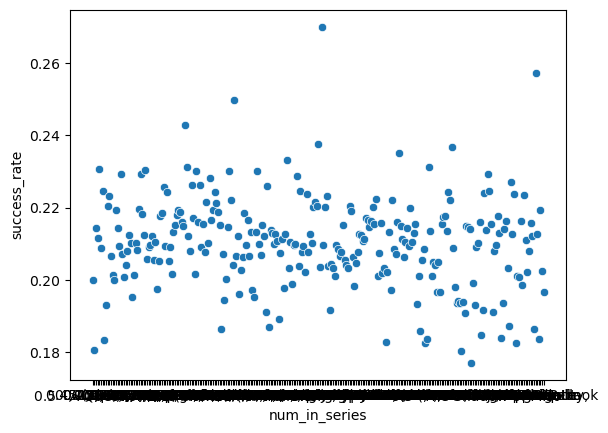

In [213]:
sns.scatterplot(sucess_by_num_in_series['success_rate'])

### Exporting json

In [130]:
export_json(dict(sucess_by_num_in_series['success_rate']), 'success_by_num_in_series/success_rate_by_num_pages')
export_json(dict(sucess_by_num_in_series['norm_rating']), 'success_by_num_in_series/norm_rating_by_num_pages')
export_json(dict(sucess_by_num_in_series['norm_num_awards']), 'success_by_num_in_series/norm_num_awards_by_num_pages')
export_json(dict(sucess_by_num_in_series['norm_num_ratings']), 'success_by_num_in_series/norm_num_ratings_by_num_pages')

# Getting publishing pattern

In [133]:
df_books['best_publish_date'] = df_books['firstPublishDate'].fillna(df_books['publishDate'])

In [144]:
import pandas as pd
from dateutil.parser import parse
import re
from datetime import datetime


# Function to clean date
def clean_date(date_str):
    try:
        # If the date contains only a year, returns None
        if re.match(r'^\d{4}$', date_str):
            return None
        
        # If the date is in MM/DD/YY format
        if re.match(r'\d{2}/\d{2}/\d{2}', date_str):
            parsed_date = pd.to_datetime(date_str, format='%m/%d/%y')
        else:
            # If the date is in a text format, use the date parser
            parsed_date = parse(date_str)
        
        # If the result date is after than 2020, correct it to 19XX
        if parsed_date >= datetime.strptime('2021-01-01', '%Y-%m-%d'):
            parsed_date = parsed_date.replace(year=parsed_date.year - 100)
        
        # Returns date in YYYY-MM-DD format
        return parsed_date.strftime('%Y-%m-%d')
    except:
        return None

# Apply the function to the 'dirty_date' column
df_books['clean_date'] = df_books['best_publish_date'].apply(clean_date)

# df_books[['clean_date', 'best_publish_date']].to_clipboard(index=False)

In [153]:
df_books_with_date = df_books[~df_books['clean_date'].isna()].copy()
df_books_with_date = df_books_with_date[df_books_with_date['clean_date']!='0458-09-24'].copy()

In [181]:
df_books_with_date['clean_date'] = pd.to_datetime(df_books_with_date['clean_date'])
df_books_with_date['day_of_week'] = df_books_with_date['clean_date'].dt.day_name().astype(str)
df_books_with_date['month_name'] = df_books_with_date['clean_date'].dt.month_name().astype(str)
df_books_with_date['clean_date'] = df_books_with_date['clean_date'].astype(str)

In [219]:
num_book_by_date = df_books_with_date.groupby('clean_date').agg({'bookId': 'count'})
num_book_by_date.rename(columns={'bookId': 'num_of_books'}, inplace=True)

num_book_by_day_of_week = df_books_with_date.groupby('day_of_week').agg({'bookId': 'count'})
num_book_by_day_of_week.rename(columns={'bookId': 'num_of_books'}, inplace=True)

num_book_by_month = df_books_with_date.groupby('month_name').agg({'bookId': 'count'})
num_book_by_month.rename(columns={'bookId': 'num_of_books'}, inplace=True)
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

num_book_by_month = num_book_by_month.reindex(new_order, axis=0)

In [220]:
num_book_by_month

,num_of_books
month_name,
January,2681
February,1005
March,1298
April,1366
May,1390
June,1198
July,1031
August,1292
September,1742


<Axes: xlabel='month_name', ylabel='num_of_books'>

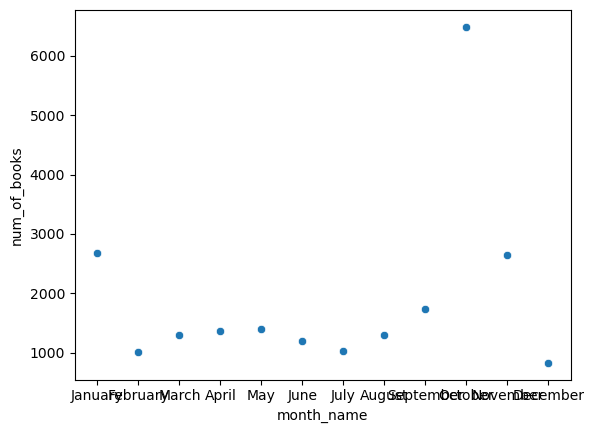

In [221]:
sns.scatterplot(num_book_by_month['num_of_books'])

In [215]:
num_book_by_date.to_csv('./output/num_books_by_time/num_book_by_date.csv')
num_book_by_day_of_week.to_csv('./output/num_books_by_time/num_book_by_day_of_week.csv')
num_book_by_month.to_csv('./output/num_books_by_time/num_book_by_month.csv')